In [1]:
#### Functions to load data

from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from collections import defaultdict
import torchvision.transforms as T
from datetime import datetime
from tensorflow import keras

In [2]:


"""
Function for loading the satellite images
Arguments:
 selectedDataset - can be "2019-07" - e.g. specific month
                          "" - all months
 pictureTypes - list defining what sort of constellations are loaded
                "dnc" - 
                "dnm" - 24-hour Microphysics RGB

 pictureSize - Size to resize images to after they are read from disk. Defaults to (256, 256).
Returns:
  2 dictionaries
  dates - dates corresponding to pictures
  pictures - satellite pictures
"""


def loadSatelliteImages(selectedDatasets=["2019-07"], pictureTypes=["dnc", "dnm"], pictureSize=(256, 256)):
    pictures = defaultdict(lambda: defaultdict(list))
    dates = defaultdict(lambda: defaultdict(list))

    for selectedDataset in selectedDatasets:
        for pictureType in pictureTypes:
            satellitePictureNames = os.listdir(os.path.join(".", "data", selectedDataset, pictureType))

            for satellitePictureName in satellitePictureNames:
                # Load image
                imageDateStr = satellitePictureName.replace("dnc-", "").replace("dnm-", "").replace(".png", "")
                #Parse date to datetime 2019-07-01-05-45
                imageDate = datetime.strptime(imageDateStr, "%Y-%m-%d-%H-%M")
                img = image.load_img(os.path.join(".", "data", selectedDataset,
                                                  pictureType, satellitePictureName),
                                     target_size=pictureSize)
                # Convert to np array and add to list
                pictures[selectedDataset][pictureType].append(np.array(img))
                dates[selectedDataset][pictureType].append(imageDate)
            dates[selectedDataset][pictureType] = np.array(dates[selectedDataset][pictureType])
            pictures[selectedDataset][pictureType] = np.array(pictures[selectedDataset][pictureType])
            #Argsort
            sortedDates = np.argsort(dates[selectedDataset][pictureType])
            dates[selectedDataset][pictureType] = dates[selectedDataset][pictureType][sortedDates]
            pictures[selectedDataset][pictureType] = pictures[selectedDataset][pictureType][sortedDates]

    return pictures, dates


In [3]:
npixel = 128

In [4]:

sat, labels = loadSatelliteImages(selectedDatasets=["2019-07", "2019-08"], pictureTypes=["dnc"], pictureSize=(npixel, npixel))

In [5]:
#plt.imshow(sat["2019-07"]["dnc"][30])

## Transforming images to dataset

In [20]:
"""
Function for creating samples out of satellite data. Each row of X contains given number 
(imagesInSample) used to predict future weather. Rows of y are similar to y, although shifted
by one time interval

Arguments
dataDict - dictionary, which contains image data
X_imagetype - the type of images that are requested for X
Y_imagetype - the type of images that are requested for y
imagesInSample - number of images in data row
"""
def createDataSetFromImages(dataDict, X_imagetype, Y_imagetype, selectChannelX=None, selectChannelY=None, imagesInSample=6):
    X = []
    y = []
    for month in dataDict.keys():
        if selectChannelX is None:
            X_subset = dataDict[month][X_imagetype]
        else:
            X_subset = dataDict[month][X_imagetype][:,:,:,selectChannelX]
            # Add a channel dimension if using only one channel
            X_subset = np.expand_dims(X_subset, axis=-1)

        if selectChannelY is None:
            y_subset = dataDict[month][Y_imagetype]
        else:
            y_subset = dataDict[month][Y_imagetype][:,:,:,selectChannelY]
            y_subset = np.expand_dims(y_subset, axis=-1)
        assert len(X_subset)==len(y_subset) # Lengths must match
        for i in range(0, len(X_subset)-imagesInSample-1):
            #Select images so that y is shifted by one frame
            selected_X = X_subset[i:i+imagesInSample]
            selected_y = y_subset[i+1:i+1+imagesInSample]
            #print(np.sum(selected_X[1]-selected_y[0]))
            X.append(selected_X)
            y.append(selected_y)
    return np.array(X), np.array(y)

In [21]:
# Normalize the data to the 0-1 range.
for dataSet in sat.keys():
    for pictureType in sat[dataSet].keys():
        sat[dataSet][pictureType] = sat[dataSet][pictureType] / 255


In [22]:
X, y = createDataSetFromImages(sat, "dnc", "dnc", 2, 2)

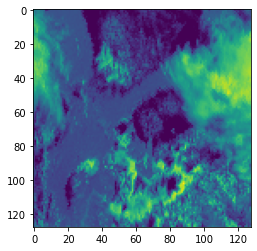

In [23]:
#Check image
plt.imshow(X[318][1])

In [10]:


# Split into train and validation sets
indexes = np.arange(X.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * X.shape[0])]
val_index = indexes[int(0.9 * X.shape[0]) :]
train_X = X[train_index]
train_y = y[train_index]
val_X = X[val_index]
val_y = y[val_index]

In [11]:
#Check that dims match
print("Training Dataset Shapes: " + str(train_X.shape) + ", " + str(train_y.shape))
print("Validation Dataset Shapes: " + str(val_X.shape) + ", " + str(val_y.shape))

Training Dataset Shapes: (5343, 6, 128, 128, 1), (5343, 6, 128, 128, 1)
Validation Dataset Shapes: (594, 6, 128, 128, 1), (594, 6, 128, 128, 1)


# Start building model

#### https://keras.io/examples/vision/conv_lstm/

#### https://github.com/xibinyue/ConvLSTM-1/blob/master/radar_forecast.py

In [17]:
from tensorflow.keras import layers
from keras.models import Sequential


In [18]:


#Defining the model
#Modified from https://keras.io/examples/vision/conv_lstm/
# Construct the input layer with no definite frame size.
#
model = Sequential()
model.add(layers.ConvLSTM2D(filters=npixel, kernel_size=(3, 3),
                   input_shape=(None, npixel, npixel, 1),
                   padding='same', return_sequences=True))
model.add(layers.BatchNormalization())

model.add(layers.ConvLSTM2D(filters=npixel, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
model.add(layers.BatchNormalization())

model.add(layers.ConvLSTM2D(filters=npixel, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
model.add(layers.BatchNormalization())

model.add(layers.ConvLSTM2D(filters=npixel, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
model.add(layers.BatchNormalization())

model.add(layers.Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))

model.compile(loss='mean_squared_error', optimizer='adadelta')





In [21]:
# Build model
#model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_4 (ConvLSTM2D)  (None, None, 128, 128, 12 594944    
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 128, 128, 12 512       
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, None, 128, 128, 12 1180160   
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 128, 128, 12 512       
_________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)  (None, None, 128, 128, 12 1180160   
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 128, 128, 12 512       
_________________________________________________________________
conv_lst_m2d_7 (ConvLSTM2D)  (None, None, 128, 128, 12

## Train model

In [23]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 30
batch_size = 5

# Fit the model to the training data.
model.fit(
    train_X,
    train_y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_X, val_y),
    callbacks=[early_stopping, reduce_lr],
)


2021-11-21 17:26:15.215567: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
   1/1069 [..............................] - ETA: 21:52:05 - loss: 0.9616

KeyboardInterrupt: 

In [21]:
model.save('savedModel_1')

2021-11-21 16:23:32.043593: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: savedModel/assets


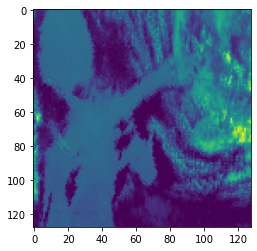

In [24]:
#plt.imshow(val_X[23][-1])

# Compare

In [46]:
#idx = 23

# Predicted

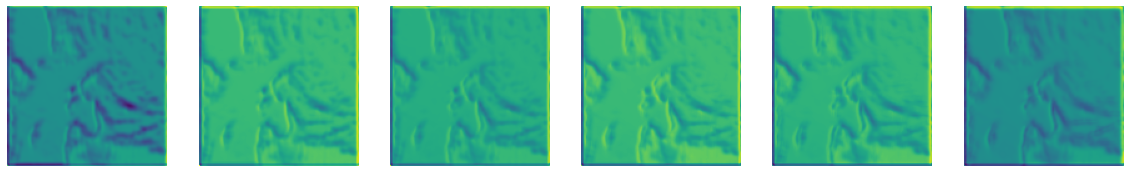

In [47]:
"""
prediction = model.predict(np.expand_dims(val_X[idx], axis=0))

plt.rcParams['figure.figsize'] = (20.0, 14.0) # set default size of plots
for i in range(len(prediction[0])):
    plt.subplot(1, 6, i+1)
    plt.imshow(prediction[0,i])
    plt.axis("off")
"""

## Real

3365.560784313725
4600.309803921568
5388.227450980392
6002.827450980392
5594.552941176471
5680.694117647059


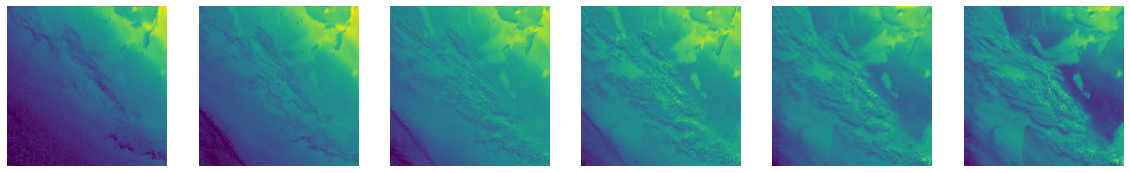

In [53]:

"""
plt.rcParams['figure.figsize'] = (20.0, 14.0) # set default size of plots
for i in range(len(val_y[idx])):
    plt.subplot(1, 6, i+1)
    print(np.sum(val_y[23,i]))
    plt.imshow(val_y[23,i])
    plt.axis("off")
"""

## Diff

-787.3068056666384
457.41863538681287
1252.6971614198358
1886.5055688516766
1472.4445196421707
1535.9357034977745


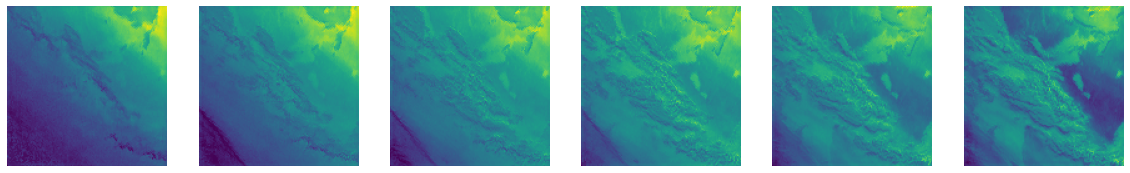

In [54]:
"""
plt.rcParams['figure.figsize'] = (20.0, 14.0) # set default size of plots
for i in range(len(val_y[idx])):
    plt.subplot(1, 6, i+1)
    diff = val_y[23,i]-prediction[0,i]
    print(np.sum(diff))
    plt.imshow(diff)
    plt.axis("off")
"""

In [26]:
idx=3

In [24]:
model = keras.models.load_model('savedModel_test')

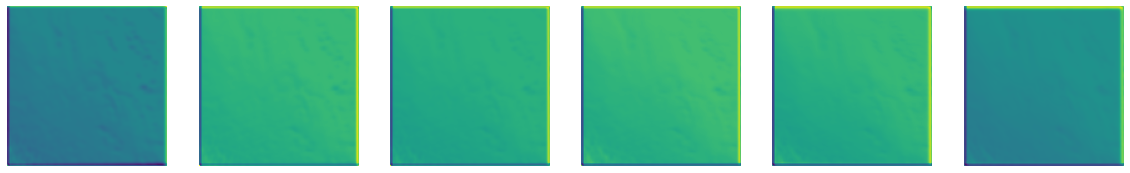

In [27]:
prediction = model.predict(np.expand_dims(val_X[idx], axis=0))

plt.rcParams['figure.figsize'] = (20.0, 14.0) # set default size of plots
for i in range(len(prediction[0])):
    plt.subplot(1, 6, i+1)
    plt.imshow(prediction[0,i])
    plt.axis("off")